In [1]:
# Imports
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm

In [2]:
train_mask_dir = "/home/ani/Documents/datasets/coco/masks/train/"
val_mask_dir = "/home/ani/Documents/datasets/coco/masks/val/"

train_images = glob(os.path.join(train_mask_dir, "*"))
val_images = glob(os.path.join(val_mask_dir, "*"))

Dims:  (100, 100, 3)


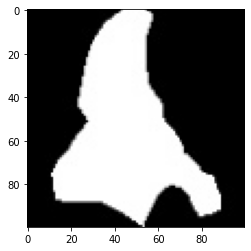

In [3]:
img_path = train_images[0]
img = cv2.imread(img_path)
print("Dims: ", img.shape)
plt.imshow(img[:,:,::-1])
plt.show()

Input Shape: (10, 100, 100, 3), Target Shape: (10, 100, 100, 1)


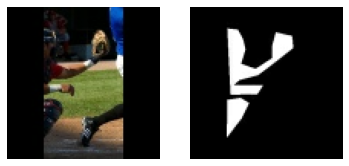

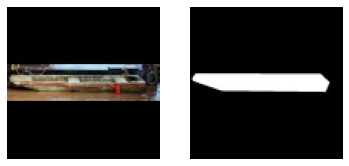

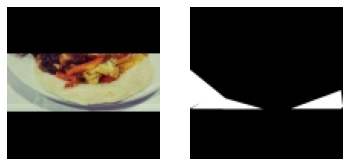

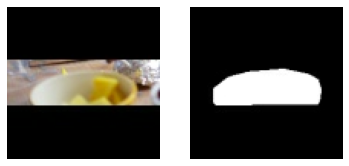

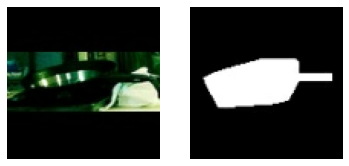

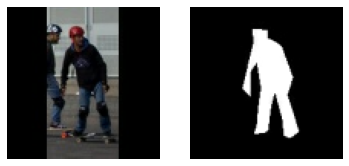

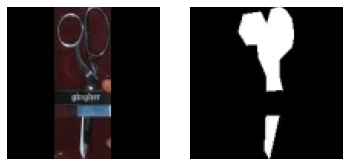

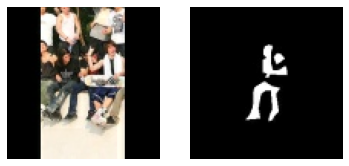

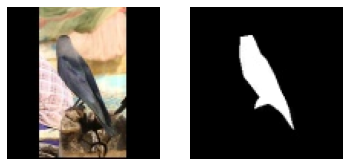

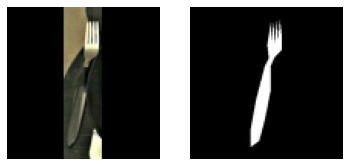

In [4]:
# A quick Tensorflow Data loader
class DataLoader:
    """
    Assuming Dataset Path Structure:
    - Train Images: /media/ActiveTraining/Datasets/COCO/images/train
    - Val Images: /media/ActiveTraining/Datasets/COCO/images/val
    - Train Masks: /media/ActiveTraining/Datasets/COCO/masks/train
    - Val Masks: /media/ActiveTraining/Datasets/COCO/masks/val
    """
    def __init__(self, masks_dir, target_shape=(100, 100)):
        masks_dir = self.__fix_glob(masks_dir)
        self.files = tf.data.Dataset.list_files(masks_dir, shuffle=True)
        self.AUTOTUNE = tf.data.experimental.AUTOTUNE
        self.target_shape = target_shape
        
    def __fix_glob(self, dir_path):
        if not dir_path.endswith("*"):
            dir_path = os.path.join(dir_path, "*")
            
        return dir_path
    
    @tf.function
    def parse_images(self, mask_path):
        mask = tf.io.read_file(mask_path)
        mask = tf.io.decode_jpeg(mask, channels=1)
        mask = tf.cast(mask, tf.float32)
        
        image_path = tf.strings.regex_replace(mask_path, "masks", "images")
        image = tf.io.read_file(image_path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.cast(image, tf.float32)
        
        mask = tf.image.resize(
            mask, 
            self.target_shape, 
        ) / 255.
        
        image = tf.image.resize(
            image, 
            self.target_shape, 
        ) / 255.
        
        return image, mask
    
    @tf.function
    def data_generator(self, batch_size=64):
        dataset = self.files.map(self.parse_images)
        dataset = dataset.repeat()
        dataset = dataset.batch(batch_size)
        dataset = dataset.prefetch(buffer_size = self.AUTOTUNE)
        return dataset
    
test_dataset = DataLoader(train_mask_dir)
batch = test_dataset.data_generator(10)
inputs, targets = next(iter(batch))
print(f"Input Shape: {inputs.shape}, Target Shape: {targets.shape}")

for i, t in zip(inputs, targets):
    plt.subplot(1, 2, 1)
    plt.imshow(i)
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(t, cmap="gray")
    plt.axis("off")
    plt.show()

In [ ]:
# Callbacks
early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=10,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)
model_ckpt_cb = tf.keras.callbacks.ModelCheckpoint(
    "weights.h5",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    save_weights_only=False,
    mode="auto",
    save_freq="epoch",
)
reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=4,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=10e-8,
)

# Model Architecture

input_img = tf.keras.Input(shape=(None, None, 3))
    
# encoding architecture
x1 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(input_img)
x2 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x1)
x3 = tf.keras.layers.MaxPool2D(padding='same')(x2)
x4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x4)
x6 = tf.keras.layers.MaxPool2D(padding='same')(x5)
encoded = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x6)

# decoding architecture
x7 = tf.keras.layers.UpSampling2D()(encoded)
x8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x7)
x9 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x8)
x10 = tf.keras.layers.Add()([x5, x9])
x11 = tf.keras.layers.UpSampling2D()(x10)
x12 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x11)
x13 = tf.keras.layers.Conv2D(64, (5, 5), activation='relu', padding='same')(x12)
x14 = tf.keras.layers.Add()([x2, x13])
decoded = tf.keras.layers.Conv2D(1, (3, 3), padding='same',activation='relu')(x14)
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.summary()

# Hyper Params
batch_size = 64
epochs = 500
lr = 0.001
target_shape=(100, 100)

opt = tf.keras.optimizers.Adam(learning_rate=lr)

autoencoder.compile(
    loss="binary_crossentropy", 
    optimizer=opt, 
    metrics=[
        "mse",
])

# Dataset Generator
train_dataset = DataLoader(train_mask_dir, target_shape=target_shape)
train_generator = train_dataset.data_generator(batch_size)

val_dataset = DataLoader(val_mask_dir, target_shape=target_shape)
val_generator = train_dataset.data_generator(batch_size)

# Calculate Num Steps
train_steps = len(list(train_dataset.files)) // batch_size + 1
val_steps = len(list(val_dataset.files)) // batch_size + 1


# Train
history = autoencoder.fit(
    train_generator,
    validation_data=val_generator,
    batch_size=batch_size, 
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    epochs=epochs, 
    callbacks=[
        early_stop_cb, 
        model_ckpt_cb, 
        reduce_lr_cb
    ])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 4864        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 6 102464      conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 6 0           conv2d_1[0][0]                   
______________________________________________________________________________________________